# **Методы машинного обучения. Лабораторная работа №4**
# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

**Постановка задачи**

Пусть дана обучающая выборка:

* `Xtrain` - матрица объекты-признаки (feature matrix);
если необходимо указать конкретный элемент матрицы, то будем использовать обозначение `Xtrain(o,f)`, где `o` - индекс объекта (соответствуют строке матрицы), а `f` - индекс признака (соответствуют столбцу матрицы);
* `Ytrain` - вектор целевого признака;
если необходимо указать конкретный элемент вектора, то будем использовать обозначение `Ytrain(o)`, где `o` - индекс объекта (соответствуют индексу вектора);
* можно рассматривать `Xtrain|Ytrain` как блочную матрицу, количество строк в матрице `Xtrain` соответствует размерности вектора `Ytrain`.


На основании алгоритма `Alg`, который использует гиперпараметры `H`, для обучающей выборки строится модель `M:Xtrain→Ytrain`, которая устанавливает соответствие между `Xtrain` и `Ytrain`: `M=Alg.fit(Xtrain,Ytrain,H)`.


Также дана тестовая выборка `Xtest` для которой на основании найденной модели M необходимо найти (предсказать) значения `Ytest=Alg.predict(M,Xtest)`.


В случае k-NN:

* в качестве алгоритма `Alg` используется метод k-ближайших соседей;
* количество ближайших соседей k является гиперпараметром алгоритма, то есть до начала работы алгоритма необходимо задать количество ближайших соседей `K`, значения `Ytrain` которых будут использованы для нахождения `Ytest`.


1.   **Подготовка данных**




In [0]:
# Установка дебаггера
! pip install ipdb -q

In [0]:
from operator import itemgetter
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as plt
import plotly.express as px
import matplotlib.pyplot as pyplot
# дебаггер
import ipdb

In [0]:
# disable warnings
pd.options.mode.chained_assignment = None

In [0]:
dataRaw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ММО/4/hotel_bookings.csv')

Выбранный датасет содержит информацию о городских и курортных отелях, а также о их посетителях. Рассмотрим данные о днях и месяцах заселения в номера различного типа в курортных отелях. 

In [0]:
# Только курортные отели
data = dataRaw[dataRaw.hotel == 'Resort Hotel']
# Бронирование которых было не отменено
data = data[dataRaw.is_canceled == 0]
data = data[['lead_time', 'adr', 'arrival_date_month', 'reserved_room_type','assigned_room_type']]
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,lead_time,adr,arrival_date_month,reserved_room_type,assigned_room_type
0,342,0.00,July,C,C
1,737,0.00,July,C,C
2,7,75.00,July,A,C
3,13,75.00,July,A,A
4,14,98.00,July,A,A
...,...,...,...,...,...
40055,212,89.75,August,A,A
40056,169,202.27,August,E,E
40057,204,153.57,August,E,E
40058,211,112.80,August,D,D


Можно заметить следующее: не все люди, бронирующие опоределнный тип номера заселяются в забронированный (например, строка 2). Именно поэтому возникает потребность в создании экспертной системы, которая позволит определить: заселится ли человек, приехавший в опеределенную дату, в забронированный заранее номер или нет.



> Данная задача является задачей классфикации: необходимо определить, относится ли тип данных к классу 1 (приезжий попадет в забронированный номер) или к классу 0 (приезжего переведут в другой номер) 



In [0]:
(sorted(data['reserved_room_type'].unique()), sorted(data['assigned_room_type'].unique()))

(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L'],
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

Проверка уникальных значений показала, что значения в колонках с резервированным и подтвержденным классом отеля отличаются в одном значении, однако они не могут различаться. Необходимо заменить все значения с `"L"` на `"I"` либо удалить из датафрейма.

In [0]:
(data[data.reserved_room_type == 'L'].shape[0], data[data.assigned_room_type == 'I'].shape[0] )

(4, 358)

Строк с зарезервированным номером типа `"L"` всего 4, поэтому их проще удалить  удаление этих строк из датасета будет наиболее правильным решением.


In [0]:
data = data.drop(data[data.reserved_room_type == 'L'].index)
data[data.reserved_room_type == 'L']

,lead_time,adr,arrival_date_month,reserved_room_type,assigned_room_type


In [0]:
print('Типы данных \n', data.dtypes, '\n')
print('Пропуски \n', data.isnull().sum())

Типы данных 
 lead_time               int64
adr                   float64
arrival_date_month     object
reserved_room_type     object
assigned_room_type     object
dtype: object 

Пропуски 
 lead_time             0
adr                   0
arrival_date_month    0
reserved_room_type    0
assigned_room_type    0
dtype: int64


Далее нам необходимо перевести категориальные признаки в числовой формат. Пропуски в датафрейме отсутствуют

In [0]:
from sklearn.preprocessing import LabelEncoder
# метод кодирования одной переменной
def encoding( dataColumn: np.ndarray ):
  le = LabelEncoder()
  fitedColumn = le.fit(dataColumn)
  transformedColumn = fitedColumn.transform(dataColumn)
  return transformedColumn

In [0]:
# Перевод категориальных параметров в числовые
data.loc[:, 'reserved_room_type'] = encoding(data['reserved_room_type'])
data.loc[:, 'assigned_room_type'] = encoding(data['assigned_room_type'])
data.loc[:, 'arrival_date_month'] = encoding(data['arrival_date_month'])
data

,lead_time,adr,arrival_date_month,reserved_room_type,assigned_room_type
0,342,0.00,5,2,2
1,737,0.00,5,2,2
2,7,75.00,5,0,2
3,13,75.00,5,0,0
4,14,98.00,5,0,0
...,...,...,...,...,...
40055,212,89.75,1,0,0
40056,169,202.27,1,4,4
40057,204,153.57,1,4,4
40058,211,112.80,1,3,3


In [0]:
print( round(data[data.reserved_room_type != data.assigned_room_type].shape[0] / data.shape[0] , 2) * 100, '%') 


25.0 %


Итого: 25% приезжих заселяются в номер, который они раннее не бронировали


In [0]:
y = []
for i in data.index:
  if( data.loc[ i , 'reserved_room_type'] == data.loc[ i , 'assigned_room_type'] ):
    y.append(1)
  else:
    y.append(0)

Произведем классификацию - заездам в бронированные номера присвоим класс 1, а в незаброннированные 0.

In [0]:
data['y_class'] = y
data.head()

,lead_time,adr,arrival_date_month,reserved_room_type,assigned_room_type,y_class
0,342,0.0,5,2,2,1
1,737,0.0,5,2,2,1
2,7,75.0,5,0,2,0
3,13,75.0,5,0,0,1
4,14,98.0,5,0,0,1


Данные приведены к подобающему виду (категориальные признаки переведены в числовые, отсутствуют пропуски, данные классифицированы). 

* `lead_time` - количество дней, прошедших от бронирования номера, до заселения
* `arrival_date_month` - месяц заселения в отель
* `reserved_room_type` - тип номера отеля



2.   **Статистики датасета**



In [0]:
localData = []
for i in data.arrival_date_month.unique():
  dataCut=data[data.arrival_date_month == i]
  localData.append( [ i, dataCut[dataCut.y_class == 1].shape[0], dataCut[dataCut.y_class == 0].shape[0] ]  )

localDf = pd.DataFrame(data=np.c_[localData], columns=['month', 'class_1', 'class_0'])

fig = go.Figure(data=[go.Bar(
            x=localDf.month, y=localDf.class_1,
            text= localDf.class_1,
            textposition='auto',
            name= 'class_1'
        )])
fig.add_trace(go.Bar( x= localDf.month, y= localDf.class_0, name='class_0', text= localDf.class_0,
            textposition='auto',))

fig.update_layout(barmode='group')
fig.show()

Количество записей, распределенное по месяцам

In [0]:
localData = []
for i in data.reserved_room_type.unique():
  dataCut=data[data.reserved_room_type == i]
  localData.append( [ i, dataCut[dataCut.y_class == 1].shape[0], \
                     dataCut[dataCut.y_class == 0].shape[0] ]  )

localDf = pd.DataFrame(data=np.c_[localData], columns=['room', 'class_1', 'class_0'])

fig = go.Figure(data=[go.Bar(
            x=localDf.room, y=localDf.class_1,
            text= localDf.class_1,
            textposition='auto',
            name= 'class_1'
        )])
fig.add_trace(go.Bar( x= localDf.room, y= localDf.class_0, name='class_0', text= localDf.class_0,
            textposition='auto',))

fig.update_layout(barmode='group')
fig.show()

Количество записей, распределенное по классам номеров отеля



3.   **Метод (алгоритм) k-ближайших соседей**

**Краткое описание метода**
* Значение целевого признака определяется на основе значений целевых признаков тех объектов, которые находятся ближе всего к искомому объекту в пространстве признаков. Один из наиболее простых методов.

* Исторически является одним из наиболее известных методов. В терминологии Data Mining рассматривался как основной алгоритм поиска по прецедентам.

* Указать автора алгоритма довольно сложно. В статье http://37steps.com/4370/nn-rule-invention/ отмечается что метод был предложен много раз в различных вариантах.

* Метод может использоваться как для классификации, так и для регресии.

* Как правило, метод k-NN показывает худшее качество, по сравнению с другими, более сложными методами.

In [0]:
dataWithoutY = data.drop(columns=['y_class']).drop(columns=['arrival_date_month']).drop(columns=['reserved_room_type'])
dataWithoutY = pd.DataFrame( data= np.c_[dataWithoutY], columns=['x1', 'x2', 'y'])
dataWithoutY.head()

,x1,x2,y
0,342.0,0.0,2.0
1,737.0,0.0,2.0
2,7.0,75.0,2.0
3,13.0,75.0,0.0
4,14.0,98.0,0.0


* `lead_time` - x1
* `adr` - x2
* `reserved_room_type` - y


In [0]:
from enum import Enum
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

class SimpleKNN:
    
    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        """
        Метод обучения, который фактически не учится, 
        а только запоминает обучающую выборку.
        Входные параметры:
        X_train - обучающая выборка (матрица объект-признак)
        y_train - обучающая выборка (вектор целевого признака)
        Возвращаемое значение: нет
        """
        #Сохраняем параметры в переменных класса
        self._X_train = X_train
        self._y_train = y_train
          
    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Вычисление Евклидова расстояния - https://en.wikipedia.org/wiki/Euclidean_distance 
        Входные параметры:
        p, q - вектора в n-мерном пространстве признаков
        """
        return sum([(pi - qi) ** 2 for pi, qi in zip (p, q)])
            
            
    def predict_for_single_object(self, K: int, \
                prediction_type: PredictionType, \
                X_o: np.ndarray, \
                Y_o: np.ndarray, \
                verbose = True, \
                verboseCount = 5  ) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []    
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку

            data_train_current_x = [x for x in self._X_train.iloc[i]] 
            # и значение ее y
            data_train_current_y = self._y_train.loc[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x) 
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x) 
            neighbors_list.append(temp_res) 
        # *** сортируем список соседей по возрастанию расстояния *** 
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу 
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))
        if verbose:
          print('**************************************')
          print('Проверяемая точка: ', X_o) 
          print('Ожидаемое значение: ', Y_o)
          dist_list = []
          for cur_y, cur_dist, _ in neighbors_list_sorted:
            dist_list.append(cur_dist)
          print()
          print('Вывод расстояния для отсортированного списка соседей:')    
          pyplot.plot(dist_list)
          pyplot.show()
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]
        if verbose:
            print('Вывод К ближайших соседей:')
            x1_list = []
            x2_list = []
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                x1_list.append(temp_x1)
                x2_list.append(temp_x2)
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
            print()
            print('Визуализация К ближайших соседей:')
            pyplot.plot(self._X_train['x1'], self._X_train['x2'], 'b.', \
                     x1_list, x2_list,  'g*', \
                    [X_o[0]], [X_o[1]], 'ro')
            pyplot.show()   
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)          
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')
                   
    
    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix, 
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)       
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]
    

In [0]:
from sklearn.model_selection import train_test_split
y = pd.DataFrame(data = np.c_[y], columns=['y'])
# Регрессия. Целевой параметр - номер комнаты (0 -7)
X_trainRegress, X_testRegress, y_trainRegress, y_testRegress = train_test_split(dataWithoutY[['x1', 'x2']], \
                                                                                 dataWithoutY[['y']], \
                                                                                 test_size=0.4, \
                                                                                 random_state=42)
# Классификация. Целевой параметр - класс заселения (в своей комнате/ в другой комнате)
X_trainClass, X_testClass, y_trainClass, y_testClass = train_test_split(dataWithoutY[['x1', 'x2']], \
                                                                                 y, \
                                                                                 test_size=0.4, \
                                                                                 random_state=42)
def changeIndex (arrayToChange):
  indexArr = list(range(0, len(arrayToChange)))
  arrayToChange.index = indexArr

for arr in [X_trainRegress, X_testRegress, y_trainRegress, y_testRegress, X_trainClass, X_testClass, y_trainClass, y_testClass]:
  changeIndex(arr) 


Ввиду высокой полотности распределения и большого количества данных, график может быть не информативным.

In [0]:
knn_class = SimpleKNN()
knn_class.fit(X_train= X_trainClass, y_train=y_trainClass)

knn_regress = SimpleKNN()
knn_regress.fit(X_train=X_trainRegress, y_train=y_trainRegress)

In [0]:
index = 2

data_test_X = [x for x in X_testClass[['x1','x2']].iloc[index]] 
data_test_Y = [y for y in y_testClass.iloc[index]]
(data_test_X, data_test_Y)

([112.0, 189.0], [1])

**************************************
Проверяемая точка:  [112.0, 189.0]
Ожидаемое значение:  [1]

Вывод расстояния для отсортированного списка соседей:


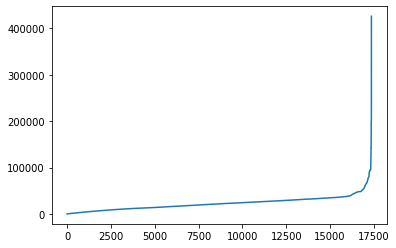

Вывод К ближайших соседей:
y=y    1
Name: 2138, dtype: int64, расстояние=2.00
y=y    1
Name: 14, dtype: int64, расстояние=4.00
y=y    1
Name: 1568, dtype: int64, расстояние=4.00
y=y    1
Name: 6060, dtype: int64, расстояние=4.00
y=y    0
Name: 3632, dtype: int64, расстояние=8.00

Визуализация К ближайших соседей:


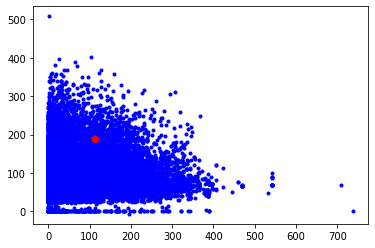

Классы, соответствующие К ближайшим соседям:
класс=1, количество элементов=4
класс=0, количество элементов=1


1

In [0]:
simple_knn_class_0 = knn_class.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_o= data_test_X, \
                          Y_o= data_test_Y, \
                          verbose=True, \
                          verboseCount= 10)
simple_knn_class_0

**************************************
Проверяемая точка:  [112.0, 189.0]
Ожидаемое значение:  [1]

Вывод расстояния для отсортированного списка соседей:


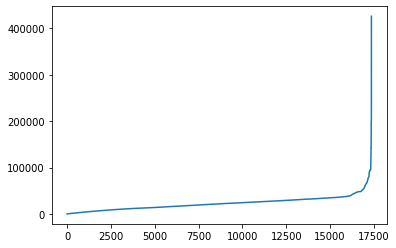

Вывод К ближайших соседей:
y=y    2.0
Name: 2138, dtype: float64, расстояние=2.00
y=y    0.0
Name: 14, dtype: float64, расстояние=4.00
y=y    0.0
Name: 1568, dtype: float64, расстояние=4.00
y=y    0.0
Name: 6060, dtype: float64, расстояние=4.00
y=y    5.0
Name: 3632, dtype: float64, расстояние=8.00

Визуализация К ближайших соседей:


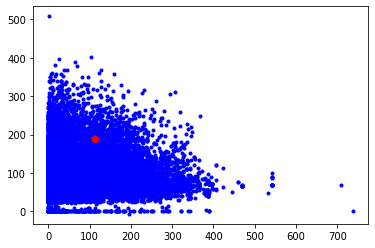

1.4

In [0]:
simple_knn_regr_0 = knn_regress.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.REGRESSION, \
                          X_o=data_test_X, \
                          Y_o=data_test_Y, 
                          verbose=True, \
                          verboseCount= 10)
simple_knn_regr_0

4. **Оценка качества построенных моделей**



In [0]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

Для дальнейшего анализа будем строить модели с помощью методов `KNeighborsRegressor` `KNeighborsClassifier` из библиотеки sklearn. Данные методы работают так же, как и `simpleKNN`


* Оценка качества классификации



> Accuracy



In [0]:
cl1_1 = KNeighborsClassifier(n_neighbors=5)
cl1_1.fit(X_trainClass, y_trainClass)
target1_0 = cl1_1.predict(X_trainClass)
target1_1 = cl1_1.predict(X_testClass)

(accuracy_score( y_trainClass, target1_0 ),  accuracy_score( y_testClass, target1_1))  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



(0.7933755760368664, 0.7358735095904614)

*`Accuracy`* показывает, что в 73,6% случаев из тестовой выборки классификация работает правильно. Необходимо рассмотреть другие метрики.



> Precision, Recall, F1

In [0]:
(precision_score( y_trainClass, target1_0 ),  precision_score( y_testClass, target1_1))  

(0.8203023462617142, 0.790738813735692)

*`Precision`* показал, что ~79% наблюдений, которые классификатор отнес к классу 1, действительно относились к первому классу.


In [0]:
 (recall_score( y_trainClass, target1_0 ),  recall_score( y_testClass, target1_1))  

(0.9258801729462631, 0.8790052053209948)

*`Recall`* показал, что ~88% наблюдений первого класса из тестовой выборки классификатор определил правильно.

In [0]:
 (f1_score( y_trainClass, target1_0 ),  f1_score( y_testClass, target1_1))  

(0.8698995321170796, 0.8325390304026294)

*`F1`* показал, что средний гармонический коэффициент между *`Recall`* и *`Precision`* равен ~83%

* Оценка качества регрессии

In [0]:
cl1_2 = KNeighborsRegressor(n_neighbors=5)
cl1_2.fit(X_trainRegress, y_trainRegress)
target2_0 = cl1_2.predict(X_trainRegress)
target2_1 = cl1_2.predict(X_testRegress)



> Средняя абсолютная ошибка



In [0]:
mean_absolute_error(y_testRegress, target2_1)

1.6444790046656297

Чем ближе *`Средняя абсолютная ошибка`* к нулю - тем лучше качество модели




> Среднее квадратическое отклонение



In [0]:
mean_squared_error(y_testRegress, target2_1)

4.233958873336789

**Вывод:** Судя по оценкам качества моделей, можно сказать, что модели классификации и регрессии с гиперпараметром К=5 не обладают должным качеством. Необходимо прибегнуть к методам кроссвалидации и решетчетого поиска для определения наиболее оптимального параметра.



5.   **Применение кроссвалидации и решетчетого поиска**



In [0]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve

In [0]:
dataWithoutY.shape[0]

28934

In [0]:
kf = ShuffleSplit(n_splits=5, test_size=0.25)
for train, test in kf.split(dataWithoutY[['x1', 'x2']], dataWithoutY[['y']]):
    print("%s %s" % (train, test))

[17512 13359 22686 ...  1887 24599 16491] [ 2319  6897 22673 ... 21044  4634 12771]
[20980 16990 28231 ...  7657  9749 16505] [ 4674 22761   544 ... 11497 19722 28454]
[24648 17572 18532 ... 16076 13742 24602] [ 2244 10032  7157 ... 21487  7604 26312]
[26765   677 19021 ... 10394 27200 24029] [ 6594  6330  6203 ...  7729 19902 27368]
[19287  7352  2302 ... 12227  1198  9606] [ 5867 23655  9679 ... 24496 11727 13714]


Ввиду большого объема данных, наиболее оптимальным будет использование метода подготовки выборки для кроссвалидации ShuffleSplit. 

In [0]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

Дальнейший скоринг будем проводить по настроенным параметрам в scoring. 

In [0]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

В качестве гиперпараметра для алгоритма KNN будем использовать параметр K (количество соседей), поэтому зараннее подготовим массив с вариацией этого параметра от 5 до 55 с шагом 5.

In [0]:
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf, scoring='accuracy')
clf_gs.fit(X_trainClass, y_trainClass)

In [0]:
clf_gs.cv_results_

{'mean_fit_time': array([0.01107001, 0.00991387, 0.01094451, 0.00954614, 0.00928464,
        0.00938892, 0.00933938, 0.00913343, 0.00975986, 0.00914516]),
 'mean_score_time': array([0.12720165, 0.13450861, 0.1324636 , 0.14025741, 0.14251366,
        0.14664245, 0.14944687, 0.15332141, 0.15528173, 0.16315107]),
 'mean_test_score': array([0.73262673, 0.73525346, 0.74958525, 0.7478341 , 0.75170507,
        0.74967742, 0.749447  , 0.750553  , 0.74986175, 0.75129032]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 25},
  {'n_neighbors': 30},
  {'n_neighbors': 35},
  {'n_neighbors': 40},
  {'n_neighbors': 45},
  {'n_neighbors': 50}],
 'rank_test_score': array([10,  9,  6,  8,  1, 

In [0]:
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
clf_gs.best_score_

0.751705069124424

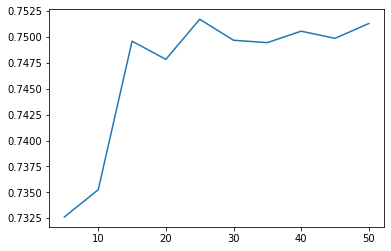

In [0]:
pyplot.plot(n_range, clf_gs.cv_results_['mean_test_score'])


**Вывод:** По результатам решетчетого поиска, наилучшее поведение модели достигается при гиперпараметре К = 25. Точность определния при этом параметре достигает 75.17%.

**6. Анализ моедли с подобранным гиперпараметром.**

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    pyplot.figure()
    pyplot.title(title)
    if ylim is not None:
        pyplot.ylim(*ylim)
    pyplot.xlabel("Training examples")
    pyplot.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    pyplot.grid()

    pyplot.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    pyplot.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    pyplot.legend(loc="best")
    return pyplot

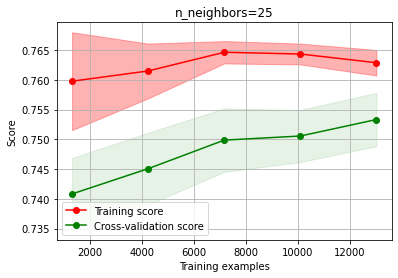

In [0]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=25), 'n_neighbors=25', 
                    X_trainClass, y_trainClass.values.ravel(), cv=kf)

Зависимость метрики *`accuracy`* на обучающей выборке от размера выборки.

In [0]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    pyplot.title(title)
    pyplot.xlabel(param_name)
    pyplot.ylabel(str(scoring))
    pyplot.ylim(0.0, 1.1)
    lw = 2
    pyplot.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    pyplot.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    pyplot.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    pyplot.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    pyplot.legend(loc="best")
    return pyplot

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

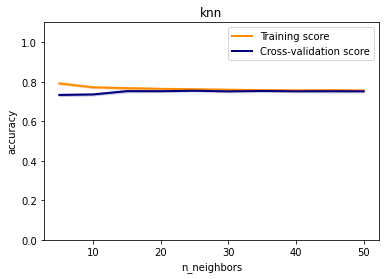

In [0]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      X_trainClass, y_trainClass.values.ravel(), 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=kf, scoring="accuracy")

Зависимость метрики *`accuracy`* на тестовой выборке от гиперпараметра К.

# **Вывод**

Исходя из вышеописанного анализа, можно придти к следующему: модель, позволяющая определить по входным параметрам (средняя сумма транзакций клиента и номер заселения) заселится ли клиент в забронированный номер или нет, наиболее оптимальна при гиперпараметре К=25. Точность предсказания достигает ~75%. Данные результаты были получены после проведения кроссвалидации (способом случайного перемешивания выборки) и решетчетого поиска (перебора параметра К от 5 до 55 с шагом 5). Были построены зависимости изменения точности модели от гиперпараметра, а также изменения точности от размера выборки. 